In [1]:
import warnings 
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime
import random
import time

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import DBSCAN
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,BatchNormalization
from keras.regularizers import l2
from xgboost import XGBRegressor

try:
    import gmplot
    import googlemaps
except ImportError:
    %pip install gmplot googlemaps 
    import gmplot
    import googlemaps

In [2]:
import sys
import os
from pathlib import Path
from dotenv import load_dotenv

parent_path = Path().cwd().parent  

#.env
dotenv_path = parent_path / '.env'
load_dotenv(dotenv_path=dotenv_path)

GOOGLE_MAPS_API_KEY = os.getenv('GOOGLE_MAPS_API_KEY')

#src folder 
src_path = parent_path / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

# Now import from features package
from features.distance import calc_distance
from features.gmaps import extract_gmaps_data,merge_gmaps_data
from features.time import extract_time_features
from features.geolocation import clustering
from features.precipitation import add_precipitation_data

In [3]:
train_df = pd.read_csv("../data/processed/eda_processed_train.csv",index_col="row_id")
test_df = pd.read_csv("../data/processed/eda_processed_test.csv",index_col="row_id")
combine = [train_df,test_df]

print("Train:",train_df.shape)
print("Test:",test_df.shape)
train_df.head()

Train: (140965, 6)
Test: (30000, 5)


,start_lng,start_lat,end_lng,end_lat,datetime,duration
row_id,,,,,,
0,-73.783279,40.644718,-73.963799,40.681320,2015-01-09 00:51:48,1815.0
1,-122.422385,37.789408,-122.419890,37.766692,2012-09-14 01:46:00,300.0
2,-73.885292,40.773060,-74.000076,40.761360,2015-04-19 20:26:57,2620.0
3,-122.401603,37.788975,-122.410958,37.796447,2012-09-03 23:48:00,360.0
4,-74.008728,40.714317,-74.006432,40.731720,2015-01-21 12:14:45,582.0


## Calculating Euclidean & Manhattan distance

In [4]:
for df in combine:
    df['manhattan'] = calc_distance(df,method='manhattan')
    df['euclidean'] = calc_distance(df,method='euclidean')

In [5]:
df.sample()

,start_lng,start_lat,end_lng,end_lat,datetime,manhattan,euclidean
row_id,,,,,,,
29463,-73.988121,40.749851,-73.985687,40.756653,2015-03-28 00:09:55,1028.146817,784.521197


## Extract Google Maps data

In [6]:
# start = 0
# interval = 10000

# #process training data in batches
# while start < len(train_df):
#     print(f"Train: Now starting with batch of the {start}'s...")
#     train = train_df.loc[start:start+interval-1]
#     train = extract_gmaps_data(train,GOOGLE_MAPS_API_KEY,test=False)
#     start+=interval

# #process test data in batches
# start = 0
# while start < len(test_df):
#     print(f"Test: Now starting with batch of the {start}'s...")
#     test = test_df.loc[start:start+interval-1]
#     test = extract_gmaps_data(test,GOOGLE_MAPS_API_KEY,test=True)
#     start += interval


In [7]:
#merging multiple gmaps csv into gmaps train and test respectively
# merge_gmaps_data()

In [8]:
#importing gmaps data
gmaps_train_data = pd.read_csv("../data/processed/gmapsdata/gmaps_train_data.csv",index_col='row_id')
gmaps_test_data = pd.read_csv("../data/processed/gmapsdata/gmaps_test_data.csv",index_col='row_id')

train_df['gmaps_distance'] = gmaps_train_data['gmaps_distance']
train_df['gmaps_duration'] = gmaps_train_data['gmaps_duration']
train_df.dropna(axis=0,inplace=True)


test_df['gmaps_distance'] = gmaps_test_data['gmaps_distance']
test_df['gmaps_duration'] = gmaps_test_data['gmaps_duration']
test_df.dropna(axis=0,inplace=True)


In [9]:
train_df.sample(5)

,start_lng,start_lat,end_lng,end_lat,datetime,duration,manhattan,euclidean,gmaps_distance,gmaps_duration
row_id,,,,,,,,,,
139016,-73.970062,40.799961,-73.955170,40.780125,2015-01-10 21:52:04,801.0,3865.903276,2539.913148,2324.0,444.0
49895,-73.952362,40.746670,-73.952362,40.746666,2015-04-08 15:15:39,4.0,0.445278,0.445278,30470.0,1514.0
111058,-73.967522,40.752544,-73.978844,40.752335,2015-04-25 22:57:25,442.0,1283.625048,955.052452,21254.0,1441.0
116463,-73.983238,40.726810,-73.962532,40.712589,2015-05-05 21:51:17,648.0,3888.055855,2357.546213,9778.0,1438.0
115180,-122.385992,37.734575,-122.392420,37.789237,2012-09-02 12:02:00,720.0,6800.507693,6111.184822,2355.0,577.0


In [10]:
test_df.sample(5)

,start_lng,start_lat,end_lng,end_lat,datetime,manhattan,euclidean,gmaps_distance,gmaps_duration
row_id,,,,,,,,,
5335,-73.994843,40.745201,-73.954048,40.803963,2015-09-11 00:52:40,11082.634545,7390.286893,10180,1638
27185,-74.008141,40.722458,-73.971642,40.763344,2015-02-20 11:42:05,8614.458795,5494.686282,6537,1609
15088,-73.968842,40.761372,-73.969070,40.786041,2015-02-03 19:29:14,2771.521362,2746.207783,3804,767
23142,-74.015907,40.707600,-73.992638,40.718750,2015-06-14 03:16:14,3831.505554,2322.833293,4147,714
5243,-122.386755,37.617723,-122.439593,37.796610,2012-09-01 00:36:00,25795.509004,20450.094722,25285,1757


sometimes there are chances that Google Maps API returns 0 distance for certain routes. Treasure Island in San Francisco has weird quirks where Google Maps fails to calculate the driving distance.

In [11]:
#Tresure Island fix
for df in combine:
    TI_df = df[df['gmaps_distance']==0].loc[df.manhattan>2000]
    #replacing them with manhattan distance
    df.loc[TI_df.index,"gmaps_distance"] = TI_df.manhattan
    #approximating gmaps_duration 
    df.loc[TI_df.index,"gmaps_duration"] = TI_df.manhattan/11.0

## Time Features

In [12]:
#add weekdays,hour,date column and drop datetime
#adding holiday column
extract_time_features(combine)
train_df.head()

,start_lng,start_lat,end_lng,end_lat,duration,manhattan,euclidean,gmaps_distance,gmaps_duration,weekday,hour,date,holiday
row_id,,,,,,,,,,,,,
0,-73.783279,40.644718,-73.963799,40.681320,1815.0,24169.910480,15778.616804,19322.0,2567.0,5,0,2015-01-09,0
1,-122.422385,37.789408,-122.419890,37.766692,300.0,2806.475682,2538.244354,2855.0,550.0,5,1,2012-09-14,0
2,-73.885292,40.773060,-74.000076,40.761360,2620.0,14080.134473,9764.679964,14693.0,1876.0,7,20,2015-04-19,0
3,-122.401603,37.788975,-122.410958,37.796447,360.0,1873.173072,1170.082524,2019.0,578.0,1,23,2012-09-03,0
4,-74.008728,40.714317,-74.006432,40.731720,582.0,2192.882649,1946.952973,2382.0,608.0,3,12,2015-01-21,0


In [13]:
train_df.columns

Index(['start_lng', 'start_lat', 'end_lng', 'end_lat', 'duration', 'manhattan',
       'euclidean', 'gmaps_distance', 'gmaps_duration', 'weekday', 'hour',
       'date', 'holiday'],
      dtype='object')

In [14]:
train_df.holiday.value_counts()

holiday
0    132602
1      3503
Name: count, dtype: int64

## Geolocations

In [15]:
clustering(train_df,test_df)

2025-09-29 03:03:36 [INFO] Preparing coordinates...
2025-09-29 03:03:36 [INFO] Preparing Clusters...
2025-09-29 03:04:04 [INFO] Preparing labels for cluster...
2025-09-29 03:04:04 [INFO] Adding cluster features to dataframes...


Number of clusters found: 5


2025-09-29 03:04:04 [INFO] Visualizing clusters...
2025-09-29 03:04:04 [INFO] Saved HTML Files in gmaps/...
2025-09-29 03:04:05 [INFO] Clustering complete!


In [16]:
train_df.columns

Index(['start_lng', 'start_lat', 'end_lng', 'end_lat', 'duration', 'manhattan',
       'euclidean', 'gmaps_distance', 'gmaps_duration', 'weekday', 'hour',
       'date', 'holiday', 'airport', 'citycenter', 'standalone'],
      dtype='object')

In [17]:
test_df.columns

Index(['start_lng', 'start_lat', 'end_lng', 'end_lat', 'manhattan',
       'euclidean', 'gmaps_distance', 'gmaps_duration', 'weekday', 'hour',
       'date', 'holiday', 'airport', 'citycenter', 'standalone'],
      dtype='object')

<Axes: >

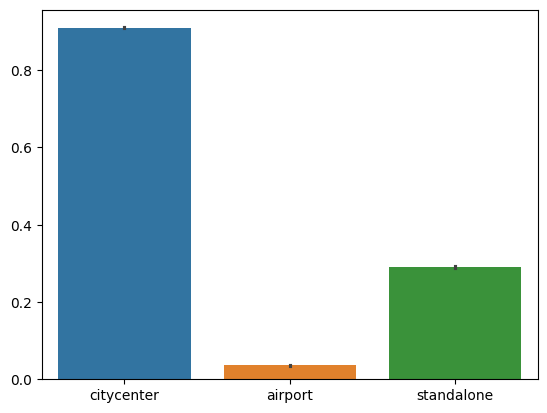

In [18]:
sns.barplot(train_df[['citycenter','airport','standalone']])

## Precipitation data

In [19]:
add_precipitation_data(combine)

Added precipitation data successfully!


In [20]:
train_df = combine[0]
test_df = combine[1]
train_df.head()

,start_lng,start_lat,end_lng,end_lat,duration,manhattan,euclidean,gmaps_distance,gmaps_duration,weekday,hour,holiday,airport,citycenter,standalone,precipitation
0,-73.783279,40.644718,-73.963799,40.681320,1815.0,24169.910480,15778.616804,19322.0,2567.0,5,0,0,0,1,1,0.07
1,-122.422385,37.789408,-122.419890,37.766692,300.0,2806.475682,2538.244354,2855.0,550.0,5,1,0,0,1,1,0.00
2,-73.885292,40.773060,-74.000076,40.761360,2620.0,14080.134473,9764.679964,14693.0,1876.0,7,20,0,0,1,1,0.00
3,-122.401603,37.788975,-122.410958,37.796447,360.0,1873.173072,1170.082524,2019.0,578.0,1,23,0,0,1,0,0.00
4,-74.008728,40.714317,-74.006432,40.731720,582.0,2192.882649,1946.952973,2382.0,608.0,3,12,0,0,1,0,0.00


## Marking Outliers

In [21]:
#marking routing errors and short trips
for df in combine: 
    df['routing_error'] = np.zeros(df.index.shape)
    df['short_trip'] = np.zeros(df.index.shape)

    df.loc[(df.gmaps_distance > 500) & (df.manhattan < 50),"routing_error"] = 1
    df.loc[(df.gmaps_distance < 500) & (df.manhattan < 50),"short_trip"] = 1

In [22]:
train_df.sample(5)

,start_lng,start_lat,end_lng,end_lat,duration,manhattan,euclidean,gmaps_distance,gmaps_duration,weekday,hour,holiday,airport,citycenter,standalone,precipitation,routing_error,short_trip
39620,-74.000221,40.726948,-73.996201,40.764881,1514.0,4670.186597,4236.270729,22609.0,1462.0,5,18,0,0,1,0,0.00,0.0,0.0
24699,-122.409248,37.780655,-122.412953,37.775128,300.0,1027.701539,696.287687,1166.0,374.0,7,9,0,0,1,0,0.00,0.0,0.0
114892,-73.989952,40.739288,-73.992851,40.738300,71.0,432.698861,268.115486,3052.0,704.0,3,3,0,0,1,0,0.01,0.0,0.0
18795,-122.413427,37.786760,-122.476292,37.782297,600.0,7494.918676,5553.010962,14608.0,1209.0,7,3,0,0,1,1,0.00,0.0,0.0
46948,-73.972603,40.786667,-73.949951,40.781044,652.0,3147.558602,2009.297573,14269.0,1393.0,2,15,0,0,1,0,0.04,0.0,0.0


In [23]:
test_df.sample(5)

,start_lng,start_lat,end_lng,end_lat,manhattan,euclidean,gmaps_distance,gmaps_duration,weekday,hour,holiday,airport,citycenter,standalone,precipitation,routing_error,short_trip
28375,-73.979446,40.755798,-73.965988,40.758869,1839.999863,1185.186420,1880,561,6,3,1,0,1,0,0.02,0.0,0.0
27037,-73.991249,40.770592,-74.002052,40.719460,6894.572662,5764.446206,6466,1149,1,16,0,0,1,0,0.00,0.0,0.0
22796,-122.395443,37.776647,-122.398388,37.761280,2038.482515,1730.164892,2563,305,6,22,0,0,1,1,0.00,0.0,0.0
8698,-74.004219,40.707397,-74.175453,40.731754,21773.090524,14699.300235,21792,2030,3,23,0,0,1,1,0.00,0.0,0.0
19598,-74.005112,40.735931,-74.001396,40.731133,947.774145,619.296468,803,280,3,22,0,0,1,0,0.00,0.0,0.0


<Axes: title={'center': 'Pearson Correlation of Features'}>

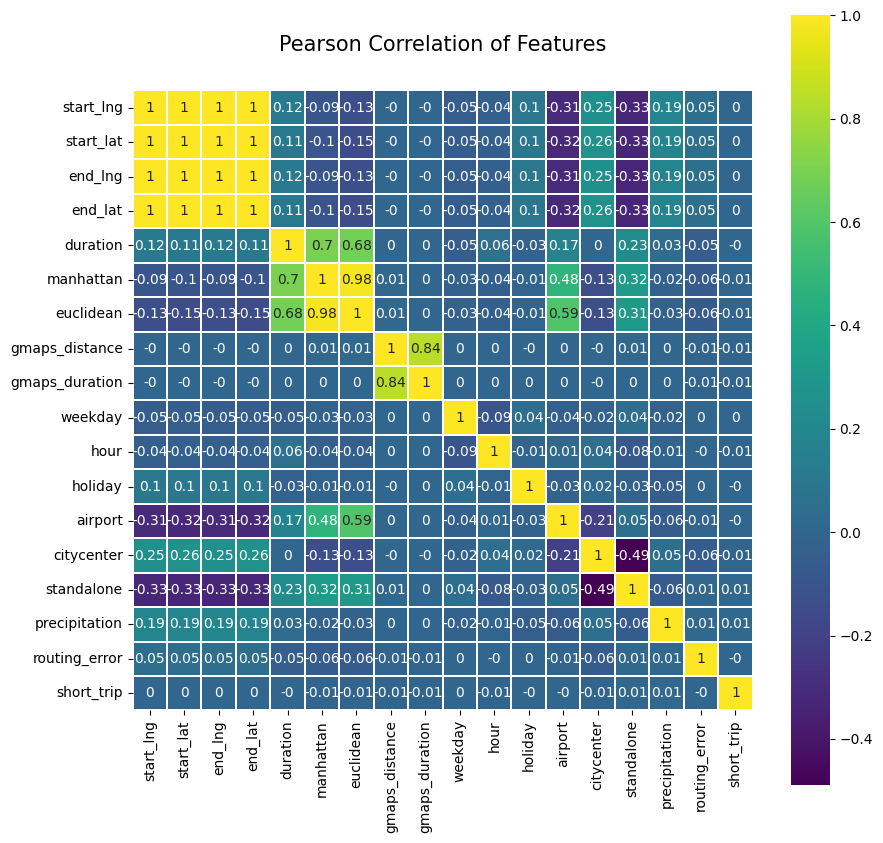

In [24]:
colormap = plt.cm.viridis
plt.figure(figsize=(10,10))
plt.title('Pearson Correlation of Features',y=1.05,size=15)
sns.heatmap(train_df.corr().round(2),linewidths=0.1,vmax=1.0, square=True, cmap=colormap,linecolor='white', annot=True)